# Programming Exercise 4: Neural Networks Learning

# Introduction
In this exercise, you will implement the backpropagation algorithm for neural networks and apply it to the task of hand-written digit recognition. Before starting on the programming exercise, we strongly recommend watching the video lectures and completing the review questions for the associated topics. 

In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, fmin_cg
import scipy.io
import math
from timeit import default_timer as timer

%matplotlib inline

## 1 Neural Networks
In the previous exercise, you implemented feedforward propagation for neural networks and used it to predict handwritten digits with the weights we provided. In this exercise, you will implement the backpropagation algorithm to learn the parameters for the neural network. 

The provided script, ex4.m, will help you step through this exercise.

In [2]:
# Setup the parameters you will use for this exercise
input_layer_size  = 400;  # 20x20 Input Images of Digits
hidden_layer_size = 25;   # 25 hidden units
num_labels = 10;          # 10 labels, from 1 to 10   
                          # (note that we have mapped "0" to label 10)


### 1.1 Visualizing the data
In the first part of ex4.m, the code will load the data and display it on a 2-dimensional plot (Figure 1) by calling the function displayData.

This is the same dataset that you used in the previous exercise. There are 5000 training examples in ex3data1.mat, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a  floating point number indicating the grayscale intensity at that location. 

The 20 by 20 grid of pixels is "unrolled" into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix X. This gives us a 5000 by 400 matrix X where every row is a training example for a handwritten digit image.

$$ X = \begin{bmatrix}
           - (x^{(1)})^T - \\
           - (x^{(2)})^T - \\
           \vdots \\
           - (x^{(m)})^T - \\
         \end{bmatrix}$$

The second part of the training set is a 5000-dimensional vector y that contains labels for the training set. The digits "1" to "9" are labeled as "0" to "8" in their natural order, and digit "0" is labeled as "9"

In [3]:
def displayData(X):
    
    m = X.shape[0]
    plt.figure()
    
    if(m == 1):
        tmp = X[0,:].reshape(20,20, order='F')
        plt.imshow(tmp, cmap='gray_r')
    else:
        display_rows = math.floor(math.sqrt(m))
        display_cols = math.ceil(m / display_rows)
        # set up array
        fig, axarr = plt.subplots(nrows=display_rows, ncols=display_cols,
                                  figsize=(10,10))

        # loop over randomly drawn numbers
        for ii in range(display_rows):
            for jj in range(display_cols):
                tmp = X[ii*display_cols+jj,:].reshape(20,20, order='F')
                axarr[ii,jj].imshow(tmp, cmap='gray_r')
                plt.setp(axarr[ii,jj].get_xticklabels(), visible=False)
                plt.setp(axarr[ii,jj].get_yticklabels(), visible=False)

        fig.subplots_adjust(hspace=0, wspace=0)

Loading and Visualizing Data ...



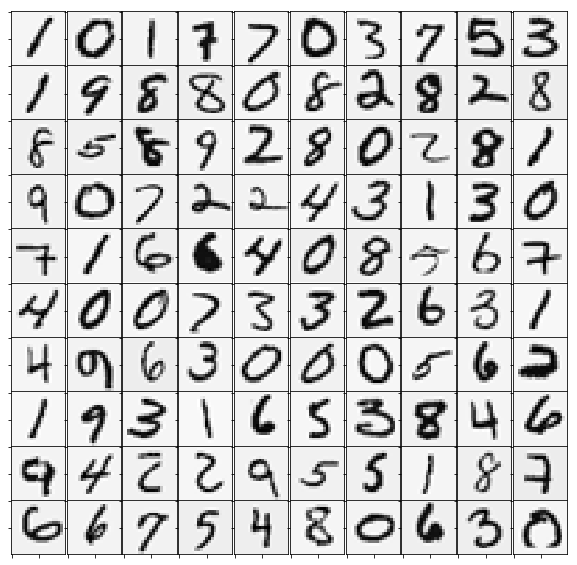

In [4]:
# =========== Part 1: Loading and Visualizing Data =============
#  We start the exercise by first loading and visualizing the dataset. 
#  You will be working with a dataset that contains handwritten digits.
#

# Load Training Data
print('Loading and Visualizing Data ...\n')

mat = scipy.io.loadmat('ex4data1.mat')
X = np.matrix(mat.get('X'))
m = X.shape[0]
y = np.matrix(mat.get('y'))

# Randomly select 100 data points to display
rand_indices = np.random.permutation(m)
sel = X[rand_indices[0:100], :]

displayData(sel)

### 1.2 Model representation
Our neural network is shown in Figure 2. It has 3 layers { an input layer, a hidden layer and an output layer. Recall that our inputs are pixel values of digit images. Since the images are of size $20\times20$, this gives us 400 input layer units (not counting the extra bias unit which always outputs +1). The training data will be loaded into the variables X and y by the ex4.m script.

You have been provided with a set of network parameters $(\Theta^{(1)}, \Theta^{(2)})$ already trained by us. These are stored in ex4weights.mat and will be loaded by ex4.m into Theta1 and Theta2. The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes).

In [5]:
# ================ Part 2: Loading Parameters ================
# In this part of the exercise, we load some pre-initialized 
# neural network parameters.

print('\nLoading Saved Neural Network Parameters ...\n')

# Load the weights into variables Theta1 and Theta2
mat = scipy.io.loadmat('ex4weights.mat')
Theta1 = np.matrix(mat.get('Theta1'))
Theta2 = np.matrix(mat.get('Theta2'))

# Unroll parameters 
nn_params = np.concatenate((Theta1.ravel() , Theta2.ravel()), axis=1).T



Loading Saved Neural Network Parameters ...



## 1.3 Feedforward and cost function
Now you will implement the cost function and gradient for the neural network. First, complete the code in nnCostFunction.m to return the cost. 

Recall that the cost function for the neural network (without regularization) is

$$ J(\theta) = \frac{1}{m}\sum^{m}_{i=1}\sum^K_{k=1}[-y^{(i)}_k log(((h_\theta(x^{(i)}))_k) - (1-y_k^{(i)})log(1-(h_\theta(x^{(i)}))_k)]$$

where $h_\theta(x^{(i)})$ is computed as shown in the Figure 2 and K = 10 is the total number of possible labels. Note that $h_\theta(x^{(i)})_k = a^{(3)}_k$ is the activation (output value) of the k-th output unit. Also, recall that whereas the original labels (in the variable y) were 1, 2, ..., 10, for the purpose of training a neural network, we need to recode the labels as vectors containing only values 0 or 1, so that

$$ y = \begin{bmatrix}
           1 \\
           0 \\
           0 \\
           \vdots \\
           0 \\
         \end{bmatrix}
         ,
         \begin{bmatrix}
           0 \\
           1 \\
           0 \\
           \vdots \\
           0 \\
         \end{bmatrix}
         ,\cdots \mbox{ or }
         \begin{bmatrix}
           0 \\
           0 \\
           0 \\
           \vdots \\
           1 \\
         \end{bmatrix}
         $$ 

For example, if $x^{(i)}$ is an image of the digit 5, then the corresponding $y^{(i)}$ (that you should use with the cost function) should be a 10-dimensional vector with $y_5$ = 1, and the other elements equal to 0.

You should implement the feedforward computation that computes $h_\theta(x^{(i)})$ for every example i and sum the cost over all examples. Your code should also work for a dataset of any size, with any number of labels (you can assume that there are always at least $K \geq 3$ labels).

Once you are done, ex4.m will call your nnCostFunction using the loaded set of parameters for Theta1 and Theta2. You should see that the cost is about 0.287629.

In [6]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoidGradient(z):
    g = np.multiply(sigmoid(z), (1-sigmoid(z)));
    return g

In [7]:
def nnCostFunction(nn_params,  input_layer_size,  hidden_layer_size,  num_labels, \
                                   X, y, lambda_t):
    #NNCOSTFUNCTION Implements the neural network cost function for a two layer
    #neural network which performs classification
    #   [J grad] = NNCOSTFUNCTON(nn_params, hidden_layer_size, num_labels, ...
    #   X, y, lambda) computes the cost and gradient of the neural network. The
    #   parameters for the neural network are "unrolled" into the vector
    #   nn_params and need to be converted back into the weight matrices. 
    # 
    #   The returned parameter grad should be a "unrolled" vector of the
    #   partial derivatives of the neural network.
    #

    # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # for our 2 layer neural network
    
    #t = timer()
    
    eps = 1e-15
    
    Theta1 = np.reshape(nn_params[0:hidden_layer_size * (input_layer_size + 1)], \
                     (hidden_layer_size, (input_layer_size + 1)));

    Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):], \
                     (num_labels, (hidden_layer_size + 1)));

    # Setup some useful variables
    m = X.shape[0]

    # You need to return the following variables correctly 
    J = 0;
    Theta1_grad = np.zeros(Theta1.shape);
    Theta2_grad = np.zeros(Theta2.shape);

    a1 = np.hstack((np.ones((m, 1)), X))
    z2 = np.matmul(a1, Theta1.T);
    a2 = sigmoid(z2);
    a2 = np.hstack((np.ones((z2.shape[0], 1)), a2))
    z3 = np.matmul(a2, Theta2.T);
    h = sigmoid(z3);

    y1 = np.zeros((y.shape[0], num_labels));
    y1[([x for x in range(0, y1.shape[0])] , tuple(y.ravel()-1))]=1
    
    J = - 1 / m * np.sum(np.multiply(y1, np.log(h)) + np.multiply((1-y1), np.log(1-h+eps)))

    Theta1Sq = np.square(Theta1)
    Theta2Sq = np.square(Theta2)
    Theta1Sq[:, 0] = 0
    Theta2Sq[:, 0] = 0

    J = J + lambda_t/2/m*(np.sum(Theta1Sq) + np.sum(Theta2Sq))

    #for i in range(0, m):
    #    delta3 = h[i,None].T - y1[i,None].T
    #    delta2 = np.multiply((Theta2.T* delta3)[1:], sigmoidGradient(z2[i,None].T));
    #    Theta2_grad = Theta2_grad + np.matmul(delta3, (a2[i,None]));
    #    Theta1_grad = Theta1_grad + np.matmul(delta2, (a1[i,None]));
    
    #back prop
    delta3 = h - y1
    delta2 = np.multiply(np.dot(delta3, Theta2)[:,1:], sigmoidGradient(z2))
        
    Delta1 = np.dot(delta2.T, a1)
    Delta2 = np.dot(delta3.T, a2)
    
    Theta1_grad = Delta1
    Theta2_grad = Delta2
    
    Theta1_grad = 1 / m * Theta1_grad + (lambda_t/m) * \
                    np.hstack((np.zeros((Theta1.shape[0], 1)), Theta1[:, 1:]))
    Theta2_grad = 1 / m * Theta2_grad + (lambda_t/m) * \
                    np.hstack((np.zeros((Theta2.shape[0], 1)), Theta2[:, 1:]))
    
    # Unroll gradients
    grad =  np.concatenate((Theta1_grad.ravel() , Theta2_grad.ravel()), axis=1).T
    
    #print("=> elasped nnCostFunction: %s s" % (timer() - t))
    
    return (J, grad)

In [8]:
# ================ Part 3: Compute Cost (Feedforward) ================
#  To the neural network, you should first start by implementing the
#  feedforward part of the neural network that returns the cost only. You
#  should complete the code in nnCostFunction.m to return cost. After
#  implementing the feedforward to compute the cost, you can verify that
#  your implementation is correct by verifying that you get the same cost
#  as us for the fixed debugging parameters.
#
#  We suggest implementing the feedforward cost *without* regularization
#  first so that it will be easier for you to debug. Later, in part 4, you
#  will get to implement the regularized cost.
#
print('\nFeedforward Using Neural Network ...\n')

# Weight regularization parameter (we set this to 0 here).
lambda_t = 0;

(J, grad) = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, \
                   num_labels, X, y, lambda_t);

print('Cost at parameters (loaded from ex4weights): %f (this value should be about 0.287629)\n' % J);


Feedforward Using Neural Network ...

Cost at parameters (loaded from ex4weights): 0.287629 (this value should be about 0.287629)



### 1.4 Regularized cost function
The cost function for neural networks with regularization is given by

$$ J(\theta) = \frac{1}{m}\sum^{m}_{i=1}\sum^K_{k=1}[-y^{(i)}_k log(((h_\theta(x^{(i)}))_k) - (1-y_k^{(i)})log(1-(h_\theta(x^{(i)}))_k)] + \frac{\lambda}{2m}[\sum^{25}_{j=1}\sum^{400}_{k=1}(\Theta^{(1)}_{j,k})^2 + \sum^{10}_{j=1}\sum^{25}_{k=1}(\Theta^{(2)}_{j,k})^2 ]$$


You can assume that the neural network will only have 3 layers, an input layer, a hidden layer and an output layer. However, your code should work for any number of input units, hidden units and outputs units. While we have explicitly listed the indices above for $\Theta^{(1)}$ and $\Theta^{(2)}$ for clarity, do note that your code should in general work with $\Theta^{(1)}$ and $\Theta^{(2)}$ of any size.

Note that you should not be regularizing the terms that correspond to the bias. For the matrices Theta1 and Theta2, this corresponds to the first column of each matrix. You should now add regularization to your cost function. Notice that you can first compute the unregularized cost function J using your existing nnCostFunction.m and then later add the cost for the regularization terms.

Once you are done, below code will call your nnCostFunction using the loaded set of parameters for Theta1 and Theta2, and $\lambda = 1$. You should see that the cost is about 0.383770. 

In [9]:
# =============== Part 4: Implement Regularization ===============
#  Once your cost function implementation is correct, you should now
#  continue to implement the regularization with the cost.
#

print('Checking Cost Function (w/ Regularization) ... \n')

#Weight regularization parameter (we set this to 1 here).
lambda_t = 1;

(J, grad) = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, \
                   num_labels, X, y, lambda_t)

print('Cost at parameters (loaded from ex4weights): %f ' \
         '\n(this value should be about 0.383770)\n' % J);

Checking Cost Function (w/ Regularization) ... 

Cost at parameters (loaded from ex4weights): 0.383770 
(this value should be about 0.383770)



## 2 Backpropagation
In this part of the exercise, you will implement the backpropagation algorithm to compute the gradient for the neural network cost function. You will need to complete the nnCostFunction so that it returns an appropriate value for grad. Once you have computed the gradient, you will be able to train the neural network by minimizing the cost function $J(\theta)$ using an advanced optimizer such as fmincg.

You will first implement the backpropagation algorithm to compute the gradients for the parameters for the (unregularized) neural network. After you have verified that your gradient computation for the unregularized case is correct, you will implement the gradient for the regularized neural network.

### 2.1 Sigmoid gradient
To help you get started with this part of the exercise, you will first implement the sigmoid gradient function. The gradient for the sigmoid function can be computed as
$$ g'(z)=\frac{d}{dz}g(z)=g(z)(1-g(z))$$
where
$$sigmoid(z) = g(z)=\frac{1}{1+e^{-z}}$$
When you are done, try testing a few values by calling sigmoidGradient(z). For large values (both positive and negative) of z, the gradient should be close to 0. When z =  0, the gradient should be exactly 0.25. Your code should also work with vectors and matrices. For a matrix, your function should perform the sigmoid gradient function on every element.

In [10]:
# ================ Part 5: Sigmoid Gradient  ================
#  Before you start implementing the neural network, you will first
#  implement the gradient for the sigmoid function. You should complete the
#  code in the sigmoidGradient.m file.
#

print('\nEvaluating sigmoid gradient...\n')

g = sigmoidGradient(np.array([-1, -0.5, 0, 0.5, 1]));
print('Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:\n  ');
print(g);


Evaluating sigmoid gradient...

Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:
  
[ 0.19661193  0.23500371  0.25        0.23500371  0.19661193]


### 2.2 Random initialization
When training neural networks, it is important to randomly initialize the parameters for symmetry breaking. One effective strategy for random initialization is to randomly select values for $\Theta^{(l)}$ uniformly in the range $[-\epsilon_{init}, \epsilon_{init}]$.
You should use $\epsilon_{init} = 0.12$. This range of values ensures that the parameters are kept small and makes the learning more efficient.
Your job is to complete randInitializeWeights.m to initialize the weights for $\Theta$; modify the file and fill in the following code:

In [11]:
def randInitializeWeights(L_in, L_out):
    #RANDINITIALIZEWEIGHTS Randomly initialize the weights of a layer with L_in
    #incoming connections and L_out outgoing connections
    #   W = RANDINITIALIZEWEIGHTS(L_in, L_out) randomly initializes the weights 
    #   of a layer with L_in incoming connections and L_out outgoing 
    #   connections. 
    #
    #   Note that W should be set to a matrix of size(L_out, 1 + L_in) as
    #   the first column of W handles the "bias" terms
    #

    # You need to return the following variables correctly 
    W = np.zeros((L_out, 1 + L_in))

    epsilon_init = 0.12
    W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init

    return W

In [12]:
# ================ Part 6: Initializing Pameters ================
#  In this part of the exercise, you will be starting to implment a two
#  layer neural network that classifies digits. You will start by
#  implementing a function to initialize the weights of the neural network
#  (randInitializeWeights.m)

print('\nInitializing Neural Network Parameters ...\n')

initial_Theta1 = np.matrix(randInitializeWeights(input_layer_size, hidden_layer_size))
initial_Theta2 = np.matrix(randInitializeWeights(hidden_layer_size, num_labels))

# Unroll parameters
initial_nn_params = np.concatenate((initial_Theta1.ravel() , initial_Theta2.ravel()), axis=1).T


Initializing Neural Network Parameters ...



### 2.3 Backpropagation

Now, you will implement the backpropagation algorithm. Recall that the intuition behind the backpropagation algorithm is as follows. Given a training example $(x^{(t)}; y^{(t)})$, we will first run a "forward pass" to compute all the activations throughout the network, including the output value of the hypothesis $h_\Theta(x)$. Then, for each node $j$ in layer $l$, we would like to compute
an "error term" $\delta^{(l)}_j$ that measures how much that node was "responsible" for any errors in our output.

For an output node, we can directly measure the dierence between the network's activation and the true target value, and use that to define $\delta^{(3)}_j$ (since layer 3 is the output layer). For the hidden units, you will compute $\delta^{(l)}_j$ based on a weighted average of the error terms of the nodes in layer $(l + 1)$.

In detail, here is the backpropagation algorithm (also depicted in Figure 3). You should implement steps 1 to 4 in a loop that processes one example at a time. Concretely, you should implement a for-loop for t = 1:m and place steps 1-4 below inside the for-loop, with the tth iteration performing the calculation on the $t^{th}$ training example $(x^{(t)}, y^{(t)})$. Step 5 will divide the accumulated. gradients by m to obtain the gradients for the neural network cost function.


1. Set the input layer's values (a(1)) to the t-th training example x(t). Perform a feedforward pass (Figure 2), computing the activations $(z^{(2)}, a^{(2)}, z^{(3)}, a^{(3)})$ for layers 2 and 3. Note that you need to add a +1 term to ensure that the vectors of activations for layers $a^{(1)}, z^{(2)}$ also include the bias unit.

2. For each output unit k in layer 3 (the output layer), set
$$\delta^{(3)}=(a^{(3)}_k - y_k).$$ where $y_k \in {0, 1}$ indicates whether the current training example belongs to class k ($y_k = 1$), or if it belongs to a difierent class ($y_k = 0$). You may find logical arrays helpful for this task (explained in the previous programming exercise).

3. For the hidden layer $l = 2$, set $$\delta^{(2)} = (\Theta^{(2)})^T\delta^{(3)}.*g'(z^{(2)})$$

4. Accumulate the gradient from this example using the following formula. Note that you should skip or remove $\delta_0^{(2)}$. In Octave/MATLAB, removing  $\delta_0^{(2)}$ corresponds to delta_2 = delta_2(2:end).
$$\Delta(l) = \Delta(l) + \delta^{(l+1)}(a^{(l)})^T$$

5. Obtain the (unregularized) gradient for the neural network cost function by dividing the accumulated gradients by $\frac{1}{m}$ : $$\frac{\partial}{\partial\Theta^{(l)}_{ij}}J(\Theta)=D^{(l)}_{ij}=\frac{1}{m}\Delta^{(l)}_{ij}$$

After you have implemented the backpropagation algorithm, the script ex4.m will proceed to run gradient checking on your implementation. The gradient check will allow you to increase your confidence that your code is computing the gradients correctly.

### 2.4 Gradient checking
In your neural network, you are minimizing the cost function $J(\Theta)$. To perform gradient checking on your parameters, you can imagine "unrolling" the parameters $\Theta^{(1)}, \Theta^{(2)}$ into a long vector $\theta$. By doing so, you can think of the cost function being $J(\theta)$ instead and use the following gradient checking procedure.

Suppose you have a function $f_i(\theta)$ that purportedly computes $\frac{\partial}{\partial\theta_{i}}J(\theta)$; you'd like to check if $f_i$ is outputting correct derivative values.

$$
\mbox{Let }
\theta^{(i+)}=\theta+\begin{bmatrix}
    0 \\
    0 \\
    \vdots \\
    \epsilon \\
    \vdots \\
    0 \\
    \end{bmatrix}
\mbox{ and }
\theta^{(i-)}=\theta-\begin{bmatrix}
    0 \\
    0 \\
    \vdots \\
    \epsilon \\
    \vdots \\
    0 \\
    \end{bmatrix}
$$

So, $\theta^{(i+)}$ is the same as $\theta$, except its i-th element has been incremented by $\epsilon$. Similarly, $\theta^{(i-)}$ is the corresponding vector with the i-th element decreased by $\epsilon$. You can now numerically verify $f_i(\theta)$'s correctness by checking, for each i, that:

$$f_i(\theta) \approx \frac{J(\theta^{(i+)}) - J(\theta^{(i-)})}{2\epsilon} $$

The degree to which these two values should approximate each other will depend on the details of J. But assuming $\epsilon = 10^{-4}$, you'll usually find that the left- and right-hand sides of the above will agree to at least 4 significant digits (and often many more).

We have implemented the function to compute the numerical gradient for you in computeNumericalGradient.m. While you are not required to modify the file, we highly encourage you to take a look at the code to understand how it works.

In the next step of ex4.m, it will run the provided function checkNNGradients which will create a small neural network and dataset that will be used for checking your gradients. If your backpropagation implementation is correct,you should see a relative difference that is less than 1e-9.

In [13]:
def debugInitializeWeights(fan_out, fan_in):
#DEBUGINITIALIZEWEIGHTS Initialize the weights of a layer with fan_in
#incoming connections and fan_out outgoing connections using a fixed
#strategy, this will help you later in debugging
#   W = DEBUGINITIALIZEWEIGHTS(fan_in, fan_out) initializes the weights 
#   of a layer with fan_in incoming connections and fan_out outgoing 
#   connections using a fix set of values
#
#   Note that W should be set to a matrix of size(1 + fan_in, fan_out) as
#   the first row of W handles the "bias" terms
#

    # Set W to zeros
    W = np.zeros((fan_out, 1 + fan_in));

    # Initialize W using "sin", this ensures that W is always of the same
    # values and will be useful for debugging
    W = np.reshape(np.sin([i for i in range(1, W.size+1)]), W.shape, order='F') / 10
    
    return W

In [14]:
def computeNumericalGradient(J, theta):
#COMPUTENUMERICALGRADIENT Computes the gradient using "finite differences"
#and gives us a numerical estimate of the gradient.
#   numgrad = COMPUTENUMERICALGRADIENT(J, theta) computes the numerical
#   gradient of the function J around theta. Calling y = J(theta) should
#   return the function value at theta.

# Notes: The following code implements numerical gradient checking, and 
#        returns the numerical gradient.It sets numgrad(i) to (a numerical 
#        approximation of) the partial derivative of J with respect to the 
#        i-th input argument, evaluated at theta. (i.e., numgrad(i) should 
#        be the (approximately) the partial derivative of J with respect 
#        to theta(i).)
#                
    numgrad = np.zeros(theta.shape)
    perturb = np.zeros(theta.shape)
    e = 1e-4
    for p in range(0, np.size(theta)):
        # Set perturbation vector
        perturb[p] = e
        loss1, _ = J(theta - perturb)
        loss2, _ = J(theta + perturb)
        # Compute Numerical Gradient
        numgrad[p] = (loss2 - loss1) / (2*e)
        perturb[p] = 0
    return numgrad

In [15]:
def checkNNGradients(lambda_t):
    #CHECKNNGRADIENTS Creates a small neural network to check the
    #backpropagation gradients
    #   CHECKNNGRADIENTS(lambda) Creates a small neural network to check the
    #   backpropagation gradients, it will output the analytical gradients
    #   produced by your backprop code and the numerical gradients (computed
    #   using computeNumericalGradient). These two gradient computations should
    #   result in very similar values.
    #

    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5

    # We generate some 'random' test data
    Theta1 = np.matrix(debugInitializeWeights(hidden_layer_size, input_layer_size))
    Theta2 = np.matrix(debugInitializeWeights(num_labels, hidden_layer_size))
    # Reusing debugInitializeWeights to generate X
    X  = debugInitializeWeights(m, input_layer_size - 1)
    y  = 1+(np.array([[i for i in range(1, m+1)]]) % num_labels).T

    
    # Unroll parameters
    nn_params = np.concatenate((Theta1.ravel() , Theta2.ravel()), axis=1).T
    
    # Short hand for cost function
    costFunc = lambda p: nnCostFunction(p, input_layer_size, hidden_layer_size, \
                                   num_labels, X, y, lambda_t)

    (cost, grad) = costFunc(nn_params);
    numgrad = computeNumericalGradient(costFunc, nn_params);
    

    # Visually examine the two gradient computations.  The two columns
    # you get should be very similar. 
    print(np.hstack((numgrad, grad)))
    print('The above two columns you get should be very similar.\n (Left-Your Numerical Gradient, Right-Analytical Gradient)\n\n')

    # Evaluate the norm of the difference between two solutions.  
    # If you have a correct implementation, and assuming you used EPSILON = 0.0001 
    # in computeNumericalGradient.m, then diff below should be less than 1e-9
    grad_diff = numgrad-grad
    grad_add = numgrad+grad
    diff = np.divide(np.linalg.norm(grad_diff), np.linalg.norm(grad_add))

    print('If your backpropagation implementation is correct, then \n the relative difference will be small (less than 1e-9). \n\nRelative Difference: %g\n' % diff)

In [16]:
# =============== Part 7: Implement Backpropagation ===============
#  Once your cost matches up with ours, you should proceed to implement the
#  backpropagation algorithm for the neural network. You should add to the
#  code you've written in nnCostFunction.m to return the partial
#  derivatives of the parameters.
#
print('\nChecking Backpropagation... \n');

#  Check gradients by running checkNNGradients
checkNNGradients(0)


Checking Backpropagation... 

[[ -9.27825235e-03  -9.27825236e-03]
 [ -3.04979153e-06  -3.04978914e-06]
 [ -1.75060082e-04  -1.75060082e-04]
 [ -9.62660596e-05  -9.62660620e-05]
 [  8.89911959e-03   8.89911960e-03]
 [  1.42869427e-05   1.42869443e-05]
 [  2.33146356e-04   2.33146357e-04]
 [  1.17982664e-04   1.17982666e-04]
 [ -8.36010761e-03  -8.36010762e-03]
 [ -2.59383071e-05  -2.59383100e-05]
 [ -2.87468727e-04  -2.87468729e-04]
 [ -1.37149707e-04  -1.37149706e-04]
 [  7.62813550e-03   7.62813551e-03]
 [  3.69883257e-05   3.69883234e-05]
 [  3.35320347e-04   3.35320347e-04]
 [  1.53247084e-04   1.53247082e-04]
 [ -6.74798369e-03  -6.74798370e-03]
 [ -4.68759787e-05  -4.68759769e-05]
 [ -3.76215583e-04  -3.76215587e-04]
 [ -1.66560294e-04  -1.66560294e-04]
 [  3.14544970e-01   3.14544970e-01]
 [  1.64090819e-01   1.64090819e-01]
 [  1.64567932e-01   1.64567932e-01]
 [  1.58339334e-01   1.58339334e-01]
 [  1.51127527e-01   1.51127527e-01]
 [  1.49568335e-01   1.49568335e-01]
 [  1.1

### 2.5 Regularized Neural Networks
After you have successfully implemeted the backpropagation algorithm, you will add regularization to the gradient. To account for regularization, it turns out that you can add this as an additional term after computing the gradients using backpropagation. 

Specifically, after you have computed $\Theta^{(l)}_{ij}$ using backpropagation, you should add regularization using

$$
\begin{align}
\frac{\partial J(\theta)}{\partial \Theta_{ij}^{(l)}}=D^{(l)}_{ij} = \frac{1}{m}\Delta^{(l)}_{ij} & & \mbox{ for $j=0$} \\
\frac{\partial J(\theta)}{\partial \Theta_{ij}^{(l)}}=D^{(l)}_{ij} = \frac{1}{m}\Delta^{(l)}_{ij} + \frac{\lambda}{m}\Theta^{(l)}_{ij} & & \mbox{ for $j>=1$}
\end{align}
$$

Note that you should not be regularizing the first column of $\Theta^{(l)}$ which is used for the bias term. Furthermore, in the parameters  $\Theta^{(l)}_{ij}$, i is indexed starting from 1, and j is indexed starting from 0. Thus,

$$ \Theta^{(l)} = \begin{bmatrix}
\Theta^{(i)}_{1,0} & \Theta^{(i)}_{1,1}  & \cdots \\
\Theta^{(i)}_{2,0} & \Theta^{(i)}_{2,1}  &  \\
\vdots &   &  \ddots\\
\end{bmatrix} $$

Now modify your code that computes grad in nnCostFunction to account for regularization. After you are done, the script will proceed to run gradient checking on your implementation. If your code is correct, you should expect to see a relative difference that is less than 1e-9.

In [17]:
# =============== Part 8: Implement Regularization ===============
#  Once your backpropagation implementation is correct, you should now
#  continue to implement the regularization with the cost and gradient.
#

print('\nChecking Backpropagation (w/ Regularization) ... \n')

#  Check gradients by running checkNNGradients
lambda_t = 3;
checkNNGradients(lambda_t);

# Also output the costFunction debugging values
debug_J, _  = nnCostFunction(nn_params, input_layer_size, \
                          hidden_layer_size, num_labels, X, y, lambda_t);

print('\n\nCost at (fixed) debugging parameters (w/ lambda = %f): %f \n(for lambda = 3, this value should be about 0.576051)\n\n' % \
      (lambda_t, debug_J));


Checking Backpropagation (w/ Regularization) ... 

[[ -9.27825235e-03  -9.27825236e-03]
 [ -1.67679797e-02  -1.67679797e-02]
 [ -6.01744725e-02  -6.01744725e-02]
 [ -1.73704651e-02  -1.73704651e-02]
 [  8.89911959e-03   8.89911960e-03]
 [  3.94334829e-02   3.94334829e-02]
 [ -3.19612287e-02  -3.19612287e-02]
 [ -5.75658668e-02  -5.75658668e-02]
 [ -8.36010761e-03  -8.36010762e-03]
 [  5.93355565e-02   5.93355565e-02]
 [  2.49225535e-02   2.49225535e-02]
 [ -4.51963845e-02  -4.51963845e-02]
 [  7.62813550e-03   7.62813551e-03]
 [  2.47640974e-02   2.47640974e-02]
 [  5.97717617e-02   5.97717617e-02]
 [  9.14587966e-03   9.14587966e-03]
 [ -6.74798369e-03  -6.74798370e-03]
 [ -3.26881426e-02  -3.26881426e-02]
 [  3.86410548e-02   3.86410548e-02]
 [  5.46101547e-02   5.46101547e-02]
 [  3.14544970e-01   3.14544970e-01]
 [  1.18682669e-01   1.18682669e-01]
 [  2.03987128e-01   2.03987128e-01]
 [  1.25698067e-01   1.25698067e-01]
 [  1.76337550e-01   1.76337550e-01]
 [  1.32294136e-01   1.

### 2.6 Learning parameters using fmincg
After you have successfully implemented the neural network cost function and gradient computation, the next step of the script will use fmin_cg to learn a good set parameters.

After the training completes, the ex4.m script will proceed to report the training accuracy of your classifier by computing the percentage of examples it got correct. If your implementation is correct, you should see a reported training accuracy of about 95.3% (this may vary by about 1% due to the random initialization). It is possible to get higher training accuracies by training the neural network for more iterations. We encourage you to try training the neural network for more iterations (e.g., set MaxIter to 400) and also vary the regularization parameter $\lambda$. With the right learning settings, it is possible to get the neural network to perfectly fit the training set.

In [18]:
# =================== Part 8: Training NN ===================
#  You have now implemented all the code necessary to train a neural 
#  network. To train your neural network, we will now use "fmincg", which
#  is a function which works similarly to "fminunc". Recall that these
#  advanced optimizers are able to train our cost functions efficiently as
#  long as we provide them with the gradient computations.
#
print('\nTraining Neural Network... \n')

#  After you have completed the assignment, change the MaxIter to a larger
#  value to see how more training helps.

#  You should also try different values of lambda
lambda_t = 1;

# Create "short hand" for the cost function to be minimized
nnCostFunction_cost = lambda p: nnCostFunction(p.T, input_layer_size, hidden_layer_size, \
                                   num_labels, X, y, lambda_t)[0]

nnCostFunction_grad = lambda p: (nnCostFunction(p.T, input_layer_size, hidden_layer_size, \
                                   num_labels, X, y, lambda_t)[1]).A1

# Now, costFunction is a function that takes in only one argument (the
# neural network parameters)
#res = minimize(nnCostFunction_cost, initial_nn_params.T, method='BFGS', jac=nnCostFunction_grad, \
#                    options={'disp': True, 'maxiter':50})
#nn_params = res.x

# run minimization
nn_params = fmin_cg(nnCostFunction_cost, initial_nn_params.T, fprime=nnCostFunction_grad, maxiter=50, disp=False)

# Obtain Theta1 and Theta2 back from nn_params
Theta1 = np.reshape(nn_params[0:hidden_layer_size * (input_layer_size + 1)], \
            (hidden_layer_size, (input_layer_size + 1)));

Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):], \
            (num_labels, (hidden_layer_size + 1)));


Training Neural Network... 



# 3 Visualizing the hidden layer
One way to understand what your neural network is learning is to visualize what the representations captured by the hidden units. Informally, given a particular hidden unit, one way to visualize what it computes is to find an input x that will cause it to activate (that is, to have an activation value $(a^{(l)}_i)$ close to 1). For the neural network you trained, notice that the ith row of $\Theta^{(1)}$ is a 401-dimensional vector that represents the parameter for the $i^{th}$ hidden unit. If we discard the bias term, we get a 400 dimensional vector that represents the weights from each input pixel to the hidden unit.

Thus, one way to visualize the "representation" captured by the hidden unit is to reshape this 400 dimensional vector into a $20 \times 20$ image and display it. The next step of ex4.m does this by using the displayData function and it will show you an image (similar to Figure 4) with 25 units, each corresponding to one hidden unit in the network.

In your trained network, you should find that the hidden units corresponds roughly to detectors that look for strokes and other patterns in the input.


Visualizing Neural Network... 



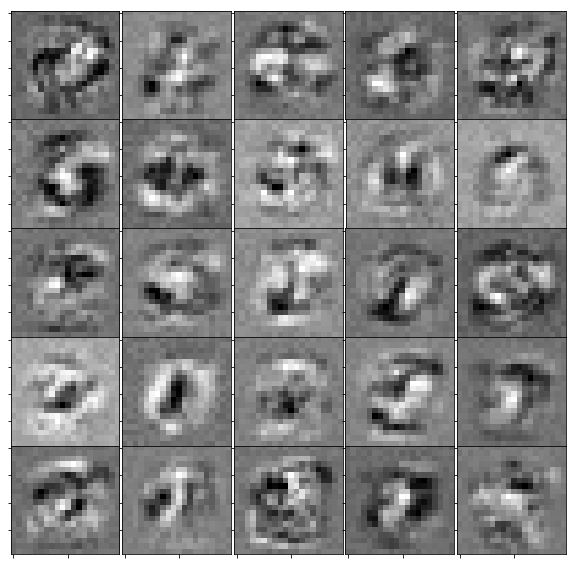

In [19]:
# ================= Part 9: Visualize Weights =================
#  You can now "visualize" what the neural network is learning by 
#  displaying the hidden units to see what features they are capturing in 
#  the data.

print('\nVisualizing Neural Network... \n')

displayData(Theta1[:, 1:]);

In [20]:
def predict(Theta1, Theta2, X):
    #PREDICT Predict the label of an input given a trained neural network
    #   p = PREDICT(Theta1, Theta2, X) outputs the predicted label of X given the
    #   trained weights of a neural network (Theta1, Theta2)

    # Useful values
    m = X.shape[0]
    num_labels, _ = Theta2.shape

    # You need to return the following variables correctly 
    p = np.zeros((m, 1))

    X_t = np.hstack((np.ones((m, 1)), X))
    a2 = X_t * Theta1.T
    z2 = sigmoid(a2)
    z2 = np.hstack((np.ones((z2.shape[0], 1)), z2))
    a3 = z2 * Theta2.T
    z3 = sigmoid(a3)
    
    p = np.argmax(z3, axis=1)
    
    return p

In [21]:
# ================= Part 10: Implement Predict =================
#  After training the neural network, we would like to use it to predict
#  the labels. You will now implement the "predict" function to use the
#  neural network to predict the labels of the training set. This lets
#  you compute the training set accuracy.

pred = predict(Theta1, Theta2, X);

print('\nTraining Set Accuracy: %f\n' % (np.mean((pred+1 == y)) * 100));


Training Set Accuracy: 96.280000



## 3.1 Optional (ungraded) exercise
In this part of the exercise, you will get to try out different learning settings for the neural network to see how the performance of the neural network varies with the regularization parameter $\lambda$ and number of training steps (the
MaxIter option when using fmincg).

Neural networks are very powerful models that can form highly complex decision boundaries. Without regularization, it is possible for a neural network to "overfit" a training set so that it obtains close to 100% accuracy on the training set but does not as well on new examples that it has not seen before. You can set the regularization $\lambda$ to a smaller value and the MaxIter parameter to a higher number of iterations to see this for youself. You will also be able to see for yourself the changes in the visualizations of the hidden units when you change the learning parameters $\lambda$ and MaxIter.

In [22]:
lams = [0, 0.01, 1, 100]
maxIters = [50, 100, 200, 400]
for ct1, lam in enumerate(lams):
    for ct2, maxIter in enumerate(maxIters):
        
        # Create "short hand" for the cost function to be minimized
        nnCostFunction_cost = lambda p: nnCostFunction(p.T, input_layer_size, hidden_layer_size, \
                                           num_labels, X, y, lam)[0]

        nnCostFunction_grad = lambda p: (nnCostFunction(p.T, input_layer_size, hidden_layer_size, \
                                           num_labels, X, y, lam)[1]).A1

        # run minimization
        nn_params = fmin_cg(nnCostFunction_cost, initial_nn_params.T, fprime=nnCostFunction_grad, maxiter=maxIter, disp=False)

        # Obtain Theta1 and Theta2 back from nn_params
        Theta1 = np.reshape(nn_params[0:hidden_layer_size * (input_layer_size + 1)], \
                    (hidden_layer_size, (input_layer_size + 1)));

        Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):], \
                    (num_labels, (hidden_layer_size + 1)));
        
        pred = predict(Theta1, Theta2, X);

        print('\nTraining Set Accuracy for lambda=%f and max iterations=%d: %f\n' % (lam, maxIter, np.mean((pred+1 == y)) * 100));


Training Set Accuracy for lambda=0.000000 and max iterations=50: 96.420000


Training Set Accuracy for lambda=0.000000 and max iterations=100: 99.460000


Training Set Accuracy for lambda=0.000000 and max iterations=200: 99.960000


Training Set Accuracy for lambda=0.000000 and max iterations=400: 100.000000


Training Set Accuracy for lambda=0.010000 and max iterations=50: 96.440000


Training Set Accuracy for lambda=0.010000 and max iterations=100: 99.240000


Training Set Accuracy for lambda=0.010000 and max iterations=200: 99.980000


Training Set Accuracy for lambda=0.010000 and max iterations=400: 100.000000


Training Set Accuracy for lambda=1.000000 and max iterations=50: 96.280000


Training Set Accuracy for lambda=1.000000 and max iterations=100: 98.440000


Training Set Accuracy for lambda=1.000000 and max iterations=200: 99.300000


Training Set Accuracy for lambda=1.000000 and max iterations=400: 99.500000


Training Set Accuracy for lambda=100.000000 and max iterations=5